In [155]:
import os
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from nltk.stem.snowball import SnowballStemmer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import seaborn
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Dense, Embedding, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
#nltk.download('all')

In [2]:
train_data = 'data/train.tsv.zip'
test_data = 'data/test.tsv.zip'
label = 'data/sampleSubmission.csv'

In [3]:
df_train = pd.read_csv(train_data, sep ='\t')
df_train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [4]:
df_test = pd.read_csv(test_data, sep='\t')
df_test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


<Axes: >

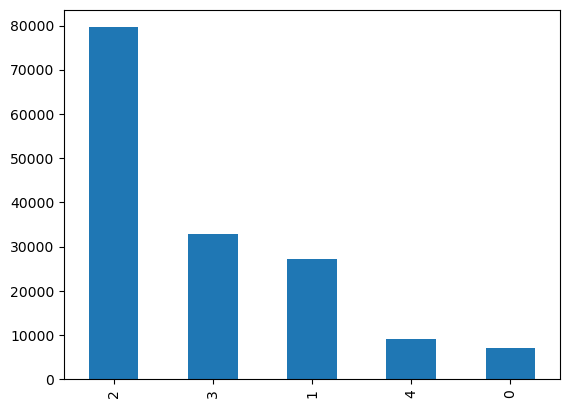

In [30]:
df_train['Sentiment'].value_counts().plot(kind='bar')

In [84]:
def clean(text):
    text = text.lower()  # Lowercase
    text = ''.join([c for c in text if c.isalpha() or c.isspace()])  # Remove non-alphabetic characters
    return text


In [86]:
df_train['Phrase'] = df_train['Phrase'].apply(clean)

In [87]:
min_count = df_train['Sentiment'].value_counts().min()-1
df_balanced = pd.DataFrame()
for label in df_train['Sentiment'].unique():
    df_label = df_train[df_train['Sentiment']== label]
    df_label_undersample = resample(df_label, replace=False, n_samples=min_count, random_state=42)
    df_balanced = pd.concat([df_balanced, df_label_undersample])

In [88]:
df_train['Sentiment'].unique()

array([1, 2, 3, 4, 0])

In [89]:
df_balanced['Sentiment'].value_counts()

1    7071
2    7071
3    7071
4    7071
0    7071
Name: Sentiment, dtype: int64

<Axes: >

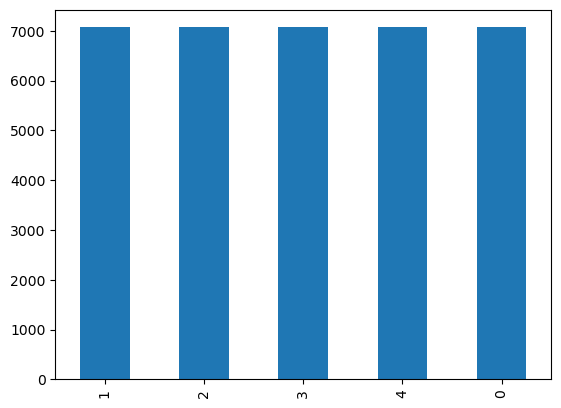

In [90]:
df_balanced['Sentiment'].value_counts().plot(kind='bar')

In [91]:
labels = df_balanced['Sentiment'].values
print(labels)
labels_ohe = to_categorical(labels, num_classes=5)
#df_balanced['Sentiment']

[1 1 1 ... 0 0 0]


In [92]:
token = Tokenizer(num_words=5000)
text =token.fit_on_texts(df_balanced['Phrase'])

In [93]:
seq = token.texts_to_sequences(df_balanced['Phrase'])

In [94]:
seq

[[258, 1, 13, 7, 9, 17, 433],
 [1382],
 [10, 472, 24, 256, 21],
 [3216, 5, 1],
 [108,
  76,
  2233,
  32,
  1567,
  5,
  1,
  406,
  3,
  1651,
  22,
  2,
  500,
  2380,
  76,
  981,
  1,
  4,
  4424,
  8,
  89,
  32,
  99,
  34,
  434],
 [118, 158, 9, 1652],
 [10, 6, 3217, 142, 120, 1182],
 [190, 109, 2, 144, 169, 18, 131],
 [2015],
 [3932, 27, 69, 1108, 186, 29, 3932, 27, 174],
 [4, 1, 1440, 3, 1653, 80, 142, 62, 344, 33, 795],
 [11, 11, 17, 1040, 137],
 [2,
  723,
  1326,
  866,
  306,
  21,
  31,
  11,
  1497,
  33,
  56,
  11,
  2381,
  130,
  38,
  1327,
  33,
  11,
  1230,
  11,
  25,
  171,
  38,
  3933],
 [1383, 345, 2965, 5, 1384, 22, 2758, 25, 146, 3, 418, 22, 2, 335, 9, 702],
 [3934],
 [4, 1, 106, 57, 105, 29, 17, 25, 44, 273, 49, 3, 1, 15, 6, 2234, 645, 4],
 [2,
  77,
  42,
  62,
  24,
  3218,
  47,
  124,
  654,
  567,
  11,
  2,
  3,
  1654,
  2382,
  5,
  234,
  2016,
  128,
  1,
  1071,
  419],
 [63, 2, 3556, 4, 655, 352, 123, 867],
 [2, 4425, 317, 25],
 [64, 58, 10, 9

In [95]:
X_train = pad_sequences(seq,maxlen=20, padding='post')

In [96]:
X_train.shape

(35355, 20)

In [156]:
model = Sequential()
model.add(Embedding(input_dim=5000,input_length=20, output_dim=10 ))
#model.add(LSTM(units=24,return_sequences=True ))
#model.add(LSTM(units=24,return_sequences=False ))
#model.add(Flatten())
#model.add(Dense(15, activation='tanh'))
model.add(LSTM(128, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))
model.add(LSTM(64, dropout=0.5, recurrent_dropout=0.5, return_sequences=False))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 20, 10)            50000     
                                                                 
 lstm_21 (LSTM)              (None, 20, 128)           71168     
                                                                 
 lstm_22 (LSTM)              (None, 64)                49408     
                                                                 
 dense_17 (Dense)            (None, 100)               6500      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_18 (Dense)            (None, 5)                 505       
                                                                 
Total params: 177,581
Trainable params: 177,581
Non-t

In [157]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [158]:
model.fit(X_train, labels_ohe, epochs=10,batch_size=10, verbose=1)

Epoch 1/10
3536/3536 [==============================] - 224s 62ms/step - loss: 1.5074 - accuracy: 0.3233
Epoch 2/10
3536/3536 [==============================] - 217s 61ms/step - loss: 1.3221 - accuracy: 0.4417
Epoch 3/10
3536/3536 [==============================] - 211s 60ms/step - loss: 1.1575 - accuracy: 0.5168
Epoch 4/10
3536/3536 [==============================] - 203s 57ms/step - loss: 1.0932 - accuracy: 0.5456
Epoch 5/10
3536/3536 [==============================] - 197s 56ms/step - loss: 1.0526 - accuracy: 0.5632
Epoch 6/10
3536/3536 [==============================] - 190s 54ms/step - loss: 1.0269 - accuracy: 0.5758
Epoch 7/10
3536/3536 [==============================] - 180s 51ms/step - loss: 1.0050 - accuracy: 0.5833
Epoch 8/10
3536/3536 [==============================] - 161s 45ms/step - loss: 0.9923 - accuracy: 0.5904
Epoch 9/10
3536/3536 [==============================] - 196s 55ms/step - loss: 0.9807 - accuracy: 0.5945
Epoch 10/10
3536/3536 [==============================] 

In [159]:
model.evaluate(X_train, labels_ohe)

1105/1105 [==============================] - 10s 9ms/step - loss: 0.8838 - accuracy: 0.6402


[0.8837807774543762, 0.6401640772819519]

In [129]:
y_pred = model.predict(X_train)

1105/1105 [==============================] - 4s 3ms/step


In [130]:
y_pred

array([[4.4819769e-02, 2.1531023e-01, 5.7894671e-01, 1.4364038e-01,
        1.7282853e-02],
       [3.6267284e-02, 1.8403839e-01, 6.3968587e-01, 1.2572140e-01,
        1.4287035e-02],
       [1.7151150e-01, 6.8225986e-01, 1.1870564e-01, 2.3134433e-02,
        4.3886160e-03],
       ...,
       [8.5116631e-01, 1.3955934e-01, 7.5817984e-03, 1.3893503e-03,
        3.0315897e-04],
       [5.6982392e-01, 3.8892436e-01, 3.2319225e-02, 7.6427334e-03,
        1.2897415e-03],
       [6.5698087e-01, 3.1824148e-01, 2.0580042e-02, 3.5373096e-03,
        6.6031521e-04]], dtype=float32)

In [150]:
y_pred_original =np.argmax(y_pred, axis=1)

In [151]:
y_train_original =np.argmax(labels_ohe, axis=1)

In [152]:
print(classification_report(y_train_original, y_pred_original))

              precision    recall  f1-score   support

           0       0.80      0.77      0.79      7071
           1       0.67      0.59      0.63      7071
           2       0.63      0.76      0.69      7071
           3       0.65      0.57      0.61      7071
           4       0.78      0.82      0.79      7071

    accuracy                           0.70     35355
   macro avg       0.70      0.70      0.70     35355
weighted avg       0.70      0.70      0.70     35355

